In [1]:
from IPython.display import HTML
from IPython.display import display

# Taken from https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
Some hidden code... to show/hide this cell's raw code input, click (or double click if stubborn!) <a href="javascript:code_toggle()">here</a>.''')
display(tag)

############### Write code below ##################
from IPython.core.display import HTML
def css_styling():
    styles = open("./ES_ML_SOSSO/colors.css", "r").read()
    return HTML(styles)
css_styling()

# CH413 : Computational Workshop - Part 1

## Machine Learning for Drug Discovery

In the last two decades, the pharmaceutical industry has invested enormously in machine learning (ML) as a tool to
transform the current paradigm of drug design and discovery. Despite the fact that
deep learning is considered by many to sit at the very top of the hype cycle, recent
collaborative efforts between some of the major pharmaceutical companies indicate that
there is a strong driving force to improve on the existing ML algorithms and thus deliver the next generation of drugs. One of the most important consequences of this ambition is the ever-increasing amount of experimental data that is being accumulated on the many functional properties and/or biomedical activities of drug-like molecules.

In this workshop, we are going to use Gaussian processes or neural networks to build a machine learning model for the solubility of a molecular dataset. The solubility of a given substance is a measure of the extent to which it dissolves in a solvent - typically water. Despite the fact that solubility is a solid-state property (you dissolve your ibuprofene pill in water, not a single molecule of ibuprofene...) up to now the field has been trying to make predictions based on the structure of single molecules in vacuum. We are breaking new ground in our research group, but that's a story for another day ([have a look here](https://pubs.rsc.org/en/content/articlelanding/2020/me/c9me00109c#!divAbstract)...)

<img src="./ES_ML_SOSSO/TOC.png">

<div class=warn>
These blue boxes contain instructions for you to follow, or stuff for you to do.
<div/>    

<br>   
    
<b> Remember: </b> Make a copy of this Notebook! <br>
<div/>

We'll start off by loading a bunch of packages. In particular, we will leverage the very convenient [scikit-learn package](https://scikit-learn.org/stable/), which allows you to play around with an impressive variety of machine learning algorithms, from neural networks to random forests. As this is about chemistry we are also going to use [the RDKit package](https://www.rdkit.org/docs/GettingStartedInPython.html), which give you access to a number of descriptors specifically design to deal with molecules. 

In [2]:
%%capture
from __future__ import division

import pandas as pd
import numpy as np 
import ES_ML_SOSSO.chemfun as cf
from numpy.linalg import eigvalsh,eigh

from rdkit import Chem # rdkit contains a number of molecular descriptors
from rdkit.Chem.rdmolops import GetAdjacencyMatrix
from rdkit.Chem import AllChem
from rdkit.Chem.Crippen import MolLogP,MolMR

from sklearn.gaussian_process import GaussianProcessRegressor 
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import Matern, WhiteKernel

import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from numpy import linalg as LA
% matplotlib inline
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole # Needed to show molecules
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions # Only needed if modifying defaults
DrawingOptions.bondLineWidth=1.8

##  The dataset
The dataset we are going to use can be downloaded for free at http://moleculenet.ai/datasets-1. It contains the solubility in $\log[\text{mols/litre}]$ of (1128) common organic small molecules in water.

In [3]:
data=pd.read_table("./ES_ML_SOSSO/dataset.dat",header=None)

In [22]:
# Let's have a look at our dataset
data

,0,1
0,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,-0.770
1,Cc1occc1C(=O)Nc2ccccc2,-3.300
2,CC(C)=CCCC(C)=CC(=O),-2.060
3,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-7.870
4,c1ccsc1,-1.330
...,...,...
1123,FC(F)(F)C(Cl)Br,-1.710
1124,CNC(=O)ON=C(SC)C(=O)N(C)C,0.106
1125,CCSCCSP(=S)(OC)OC,-3.091
1126,CCC(C)C,-3.180


## The SMILES format
Our database contains 1128 lines, one line / molecule. In each line, we have the structure of the molecule (1st column) and its solubility (2nd column). The structure is encoded in the so-called [SMILES format](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system), which contains a limited amount of information about the structure - chiefly the identity of the atoms and their connectivity (i.e. which bonds are helding them together). A SMILES structure is thus 2D representation of a molecule - let's have a look...

In [25]:
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules

smiles=data[0].values

In [27]:
logS=data[1].values

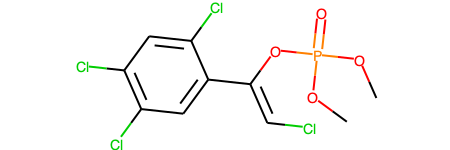

In [33]:
# Draw the structure 
test_mol=Chem.MolFromSmiles(smiles[-1])

# Visualize the structure
test_mol

<div class=warn>
Add hydrogen atoms to the structure of the last molecule within the dataset and visualize the result. Have a look
<div/>

[here](https://www.rdkit.org/docs/GettingStartedInPython.html)

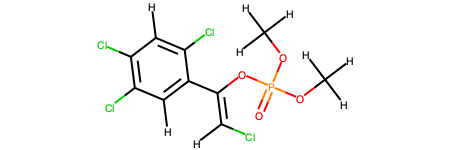

In [35]:
test_mol_with_H = Chem.AddHs(test_mol)
test_mol_with_H

In [6]:
# Setting indices to know how data is split 
indices=np.arange(len(smiles))

In [40]:
# # 
# # X_train -> training set of the molecular structures
# # X_test  -> test set of the molecular structures
# # y_train -> training set of the solubility values
# # y _test -> test set of the solubility values
# X_train, X_test, y_train, y_test = train_test_split(smiles, logS, test_size=0.1)
# print("We have ", len(X_test), "molecules in the test set, out of a total of", len(smiles))

We have  113 molecules in the test set, out of a total of 1128


In [42]:
# # Load saved train/test sets...
# # Feel free to create your own train/test splits...
# Train=np.load('./ES_ML_SOSSO/Train.npy',allow_pickle = True)
# Test=np.load('./ES_ML_SOSSO/Test.npy',allow_pickle = True)
# TrainTargets=np.load('./ES_ML_SOSSO/TrainTargets.npy',allow_pickle = True)
# TestTargets=np.load('./ES_ML_SOSSO/TestTargets.npy',allow_pickle = True)
# # Train -> X_train
# # Test -> X_test
# # TrainTargets -> y_train
# # TestTargets -> y_test

In [60]:
Train, Test, TrainTargets , TestTargets = train_test_split(smiles, logS, test_size=0.1)

In [64]:
# Convert into a different format (rdkit internal)
MFSTR=cf.SMILES2MOLES(Train)
MFSTE=cf.SMILES2MOLES(Test)

In [65]:
# Choosing the descriptors for training (SDTR) and test (SDTE) sets. 
from rdkit.Chem import Descriptors

In [66]:
SDTR=[]
for m in MFSTR:
    desc=[]
    desc.append(Chem.Lipinski.HeavyAtomCount(m))   # Number of heavy atoms within the molecule
    desc.append(Descriptors.TPSA(m))               # from J. Med. Chem. 43:3714-7, (2000)
    desc.append(Descriptors.NumHAcceptors(m))
    SDTR.append(desc)
    
SDTE=[]
for m in MFSTE:
    desc=[]
    desc.append(Chem.Lipinski.HeavyAtomCount(m))
    desc.append(Descriptors.TPSA(m))
    desc.append(Descriptors.NumHAcceptors(m))
    SDTE.append(desc)

<div class=warn>

* Modify the list of descriptors using rdkit built-in descriptors (a list can be found [here](http://www.rdkit.org/docs/GettingStartedInPython.html#list-of-available-descriptors))<br>
* Motivate your choice (in a Markdown cell)

<div/>

### Gaussian process

In [67]:
# Use a Gaussian process (GP) to fit our training set

# Choosing the kernel: radial basis function, initial lengthscale =1

kernel=RBF(length_scale_bounds=(5e-02,10)) 

gp=GaussianProcessRegressor(kernel=kernel,normalize_y=True,n_restarts_optimizer=10,alpha=1e-4);

# Fit our GP model
gp.fit(SDTR,TrainTargets);

In [68]:
# Use the trained GP to predict the solubility of our training set...
TrainPred=gp.predict(SDTR).reshape(-1,1)
# ... and of our test set
TestPred=gp.predict(SDTE).reshape(-1,1)
# The reshape(-1,1) bit is needed to convert numpy arrays into scikit-learn compatible inputs...

# #
# for loop (over all the test points)
# TestPred=gp.predict(<1 datapoint at the time>).reshape(-1,1)
# -> variance for that particular point

In [69]:
from sklearn.metrics import mean_squared_error

# How are we doing? 
# Let us calculate the mean squared error of our prediction for the training set 
# with respect to the actual solubility values
mse_train=mean_squared_error(TrainTargets,TrainPred)
print("MSE (training)) = ", mse_train)

# Now let's do the same for the test set...
mse_test=mean_squared_error(TestTargets,TestPred)
print("MSE (test)) = ", mse_test)

MSE (training)) =  0.17687322198838892
MSE (test)) =  1.4251251881368152


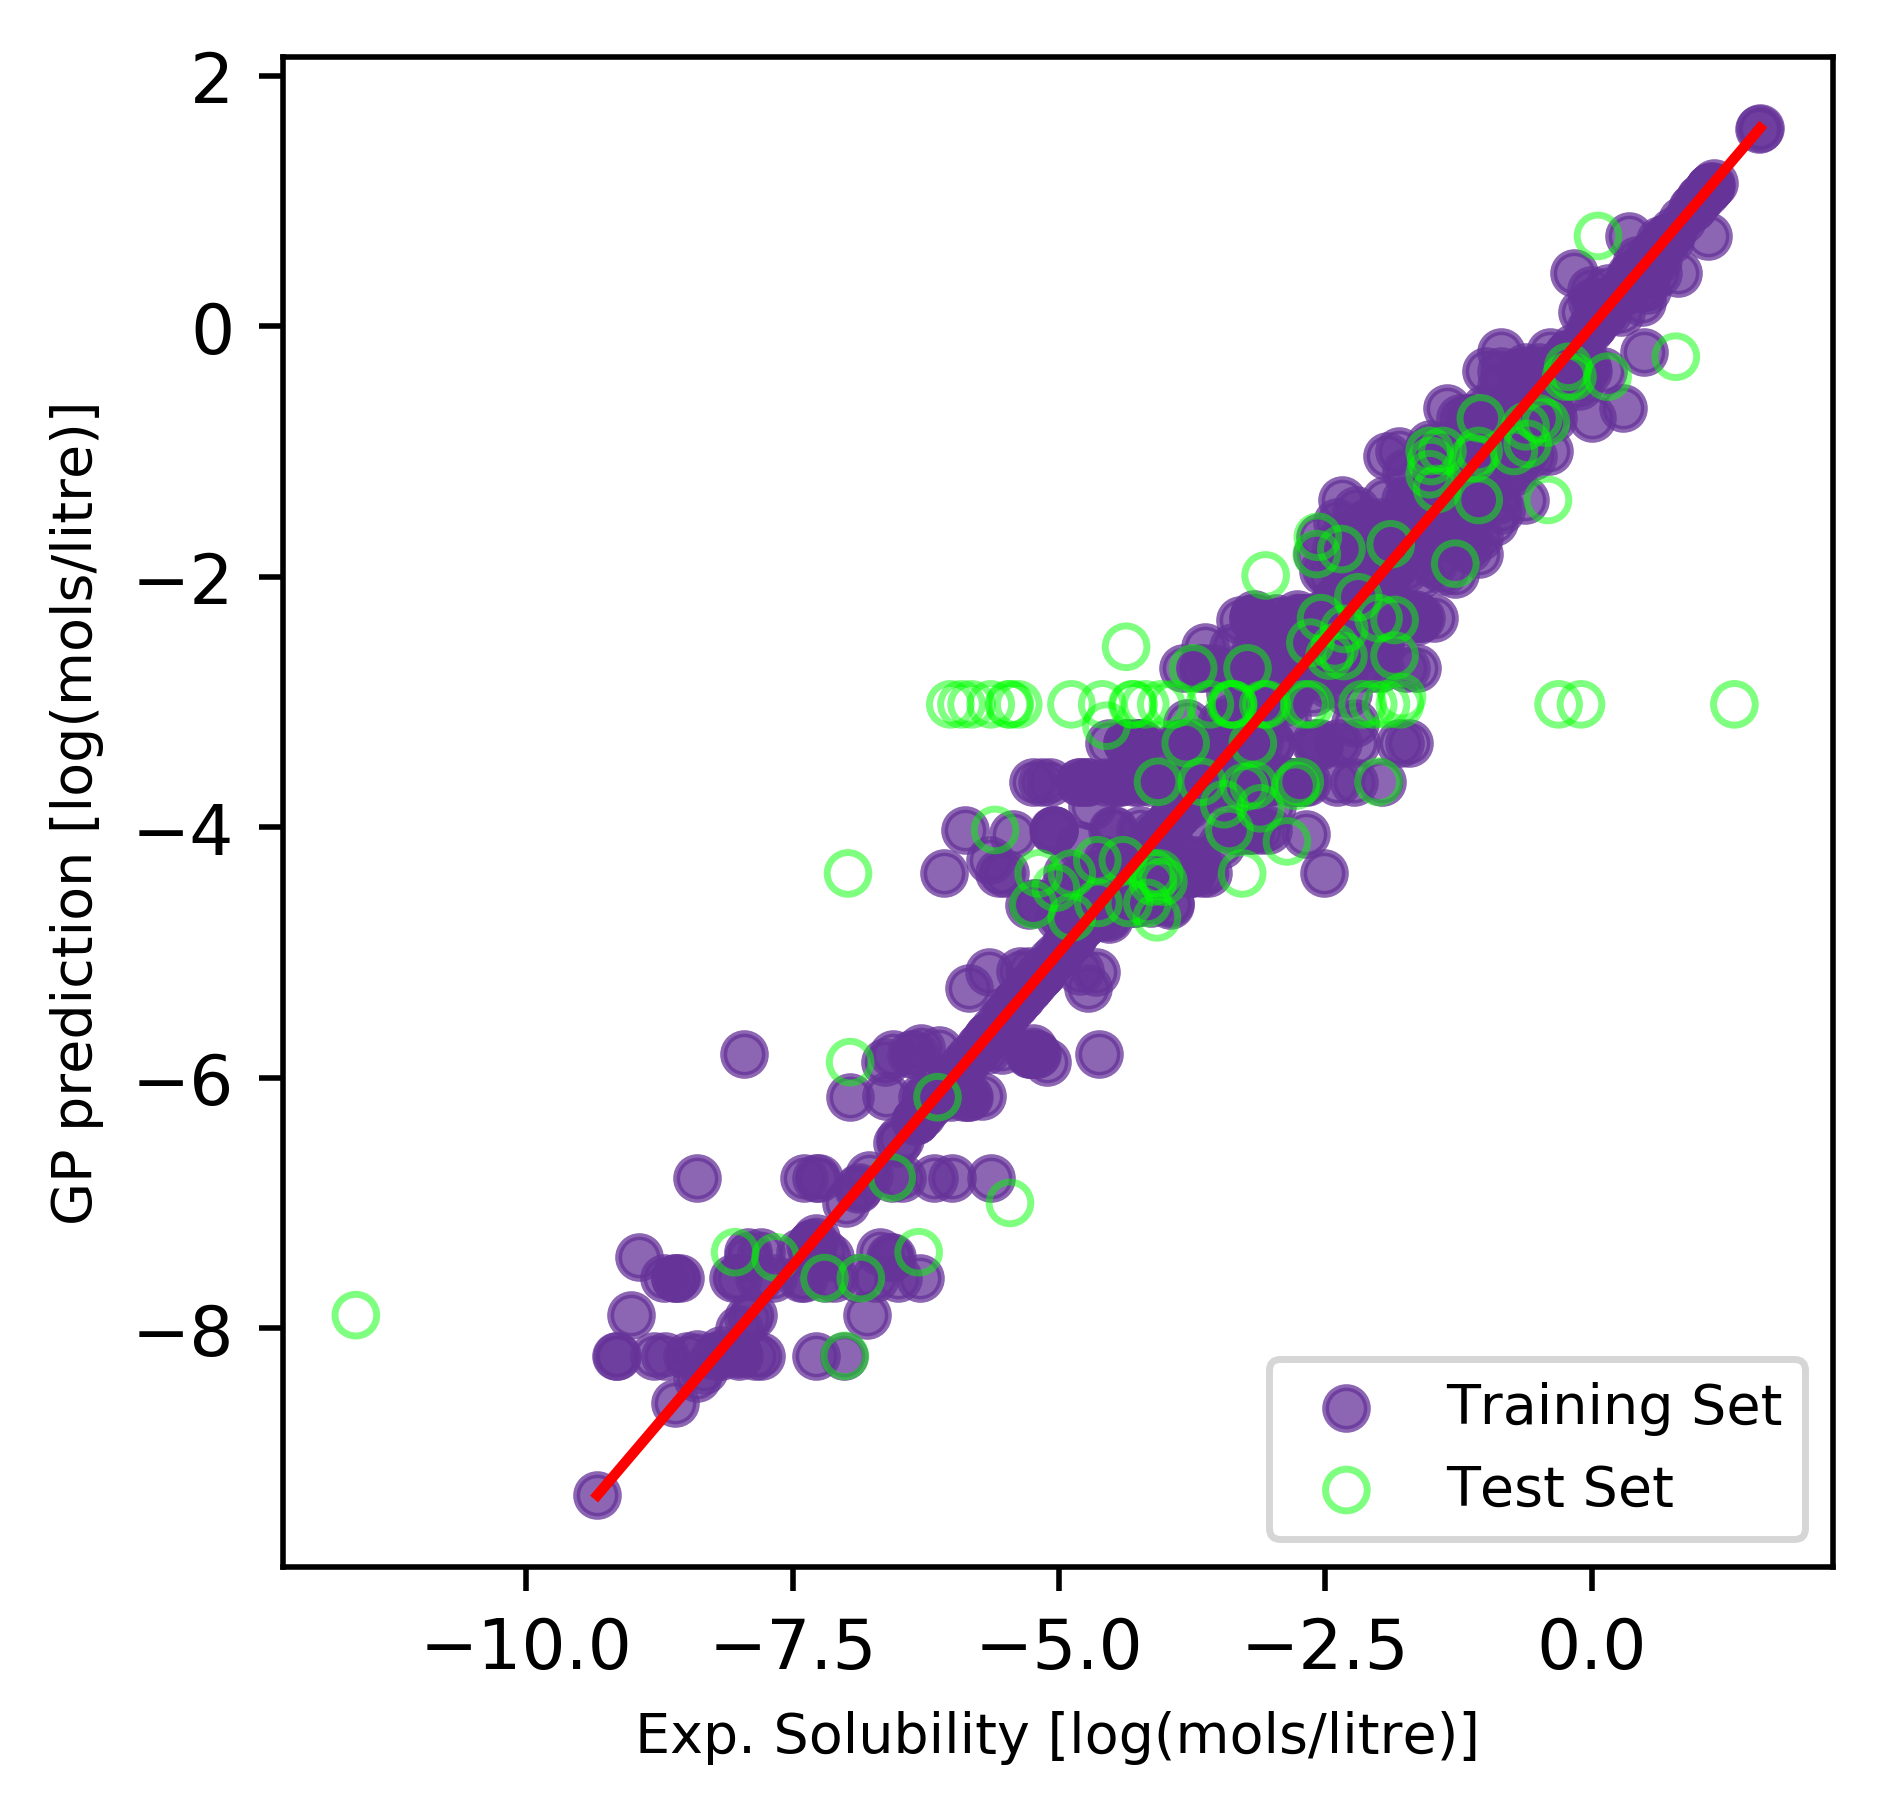

In [70]:
# Let's have a look!
fig=plt.figure(num=None,figsize=(4,4),dpi=500,facecolor='w',edgecolor='k')
plt.xlabel('Exp. Solubility [log(mols/litre)]',fontsize=8)
plt.ylabel('GP prediction [log(mols/litre)]',fontsize=8)
x = np.linspace(min(TrainTargets), max(TrainTargets), 1000)
plt.plot(x, x + 0, '-r')
plt.scatter(TrainTargets,TrainPred,color='rebeccapurple',alpha=0.75,label='Training Set')
plt.scatter(TestTargets,TestPred,color='lime',alpha=0.5,label='Test Set',facecolors='none')
plt.legend(fontsize=8,loc=4);
#plt.savefig('4.png');

### Neural network

Typically, a neural network’s weights are initialized as small random numbers (more often than not between -1 and 1, but you can play around with that). Thing is, neural networks often behave poorly when either the target values and the values of the descriptors are much larger than the weights. 

In fact, this issue affect to an extent all those machine learning algorithms that use a weighted sum of the input (such as nearal networks) or distance measures (such as support vector machines).

In the case of Gaussian processes, this issue is way less severe: while it is true that you probably don't want to learn about the mean of your target values (we obviously care about the covariance matrix instead!), you can always rescale the latter in such a way to have a zero mean - something that most implmentation do by default.

In the case of e.g. neural networks, this "pre-processing" of the data is more nuanced and can have important consequences on the accuracy/reliability of your model/predictions. You have many options to pre-process both your features and your target values (see e.g. [here](https://scikit-learn.org/stable/modules/preprocessing.html)): here, we are going to apply a popular one known as standardization; basically, we rescale our target values (we are not going to do it for the features as they are quite heterogeneous, which opens a different can of worms...) in such a way to obtain a distribution of them characterised by zero mean and standard deviation equal to one.

Before we do that, though, it's probably best to have a look at the distribution of our original target values - that is because, if they are incredibly sparse, it wouldn't make much sense to reduce them to a standardised distribution...

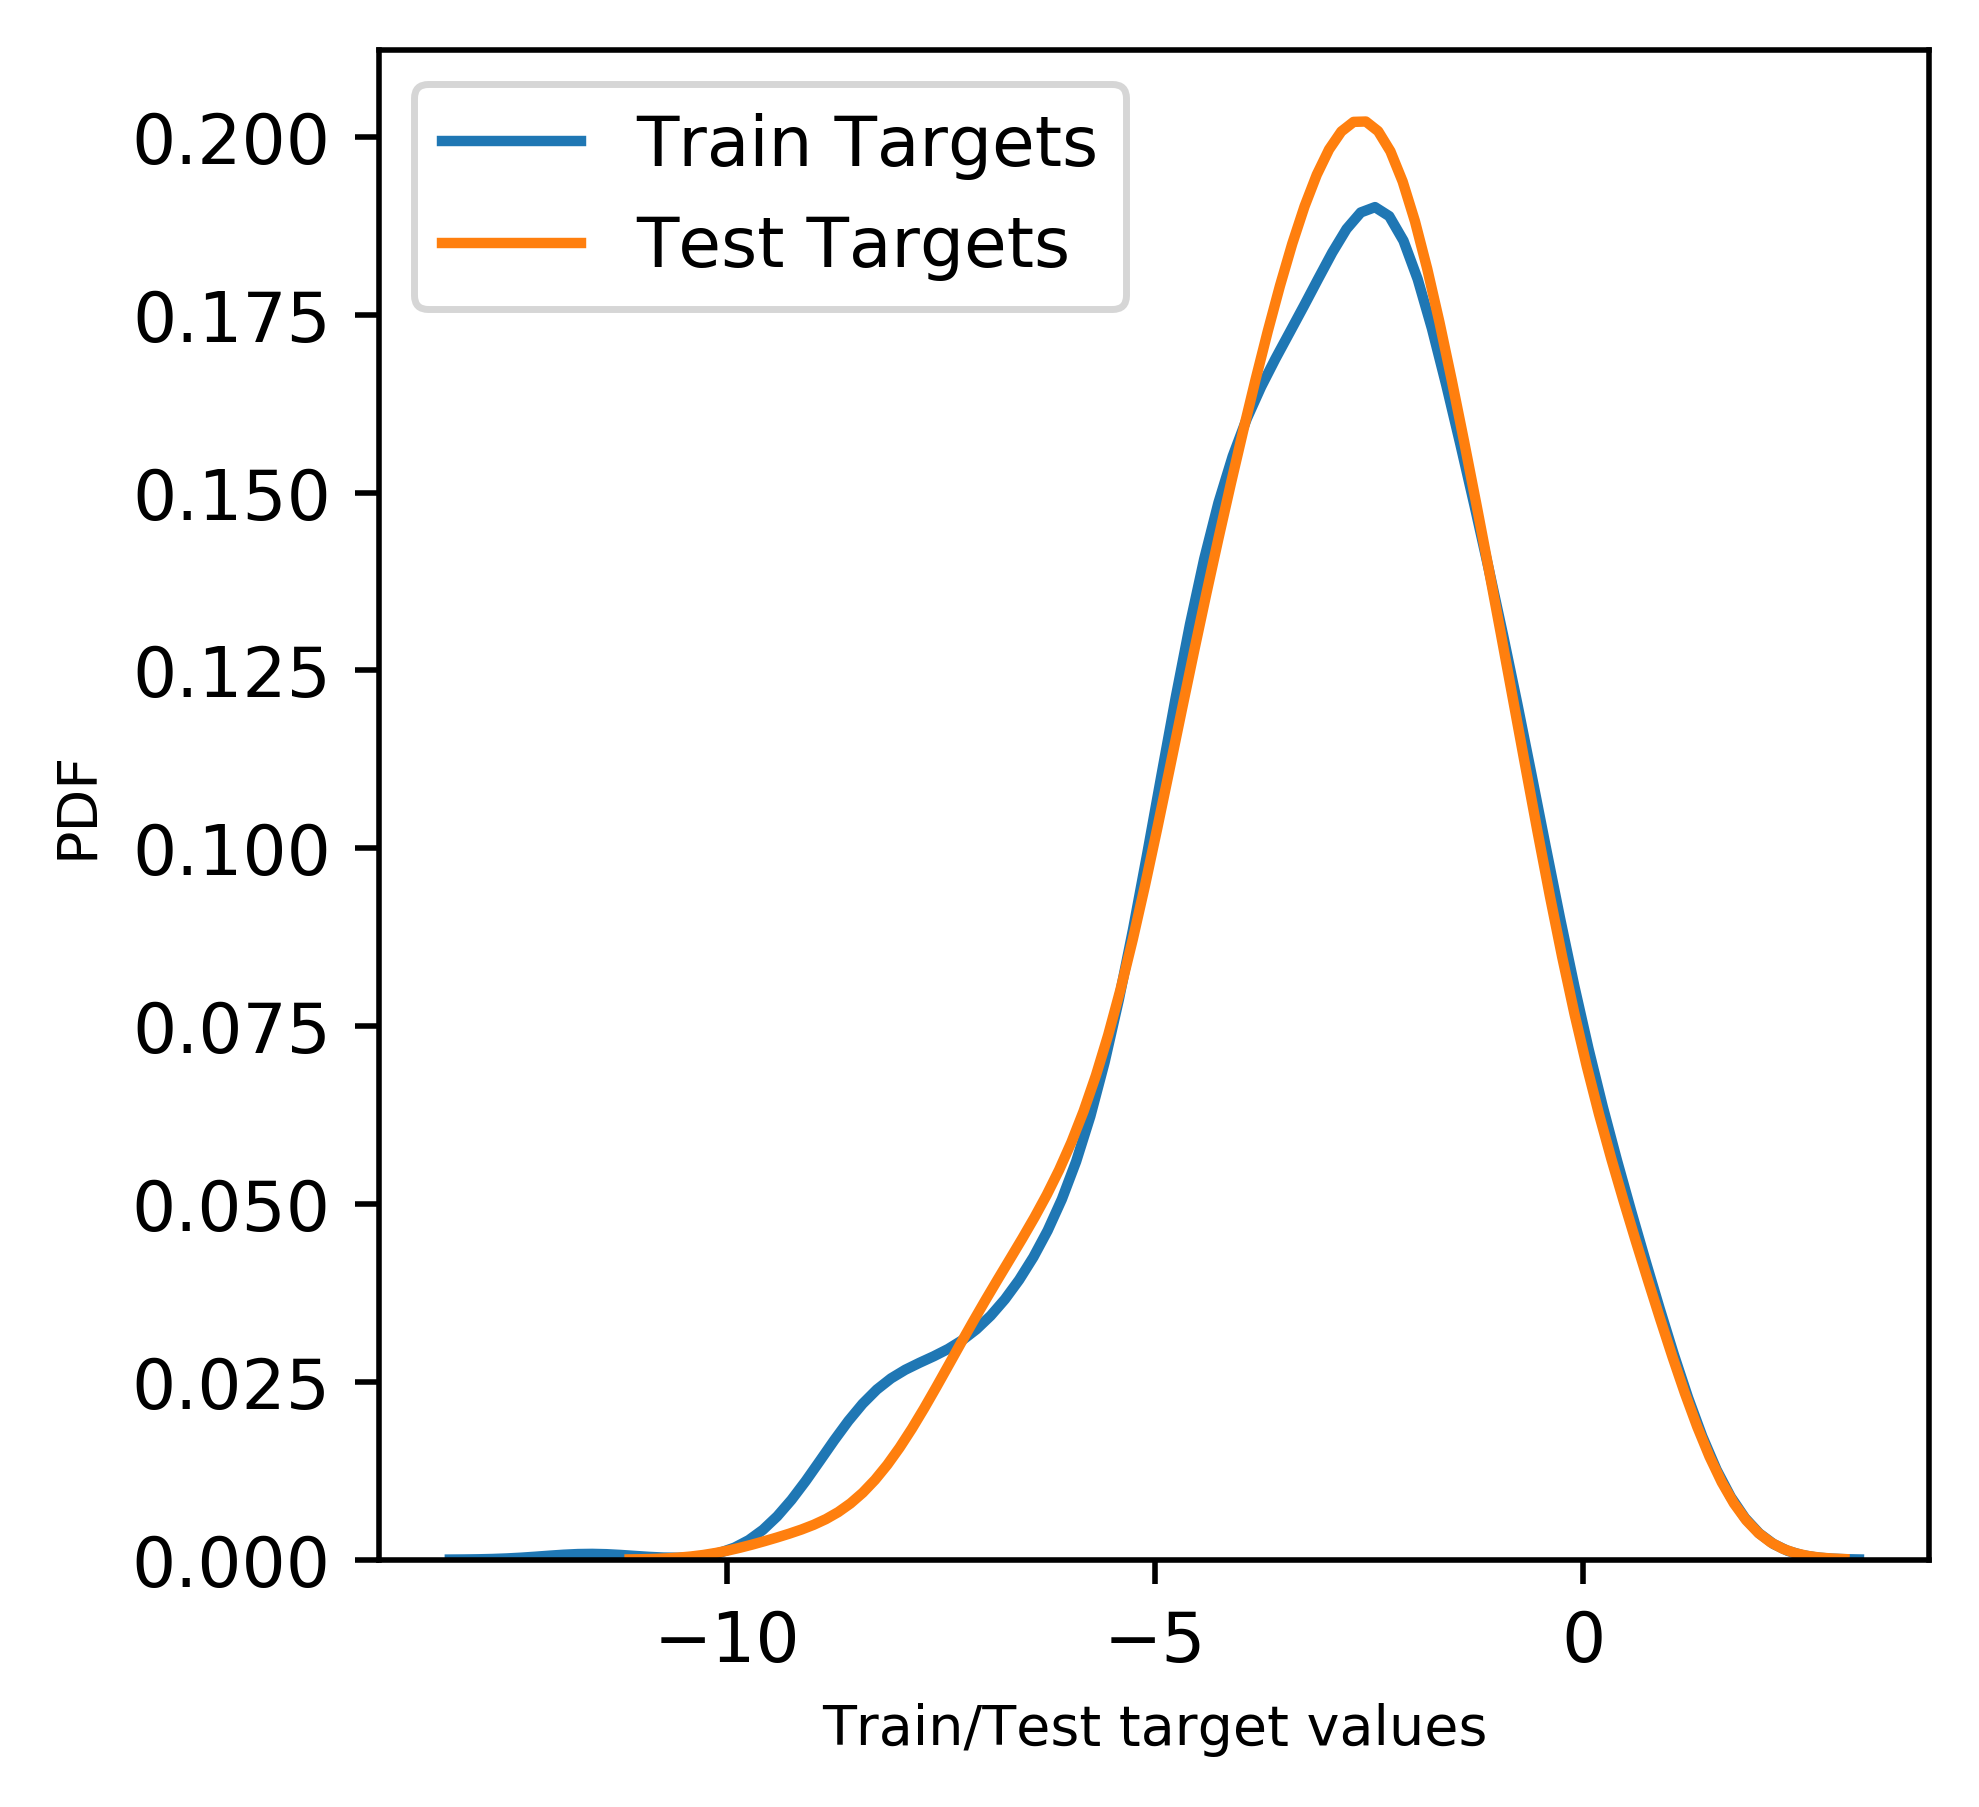

In [15]:
import seaborn as sns

# PDF of the Train/Test Targets - no standardization
fig=plt.figure(num=None,figsize=(4,4),dpi=500,facecolor='w',edgecolor='k')
sns.distplot(TrainTargets, rug=False, label="Train Targets", hist=False)
sns.distplot(TestTargets, rug=False, label="Test Targets", hist=False)
plt.xlabel('Train/Test target values',fontsize=8)
plt.ylabel('PDF',fontsize=8)
plt.show()

In [56]:
# Using the scikit-learn Standard scaler on our target values, both training and test
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
TrainTargets_s = scaler.fit_transform(TrainTargets.reshape(-1, 1))
TestTargets_s = scaler.fit_transform(TestTargets.reshape(-1, 1))

# Let's check we got this right...
print('Mean:', round(TrainTargets_s[:,0].mean()))
print('Standard deviation:', TrainTargets_s[:,0].std())

Mean: -0.0
Standard deviation: 1.0


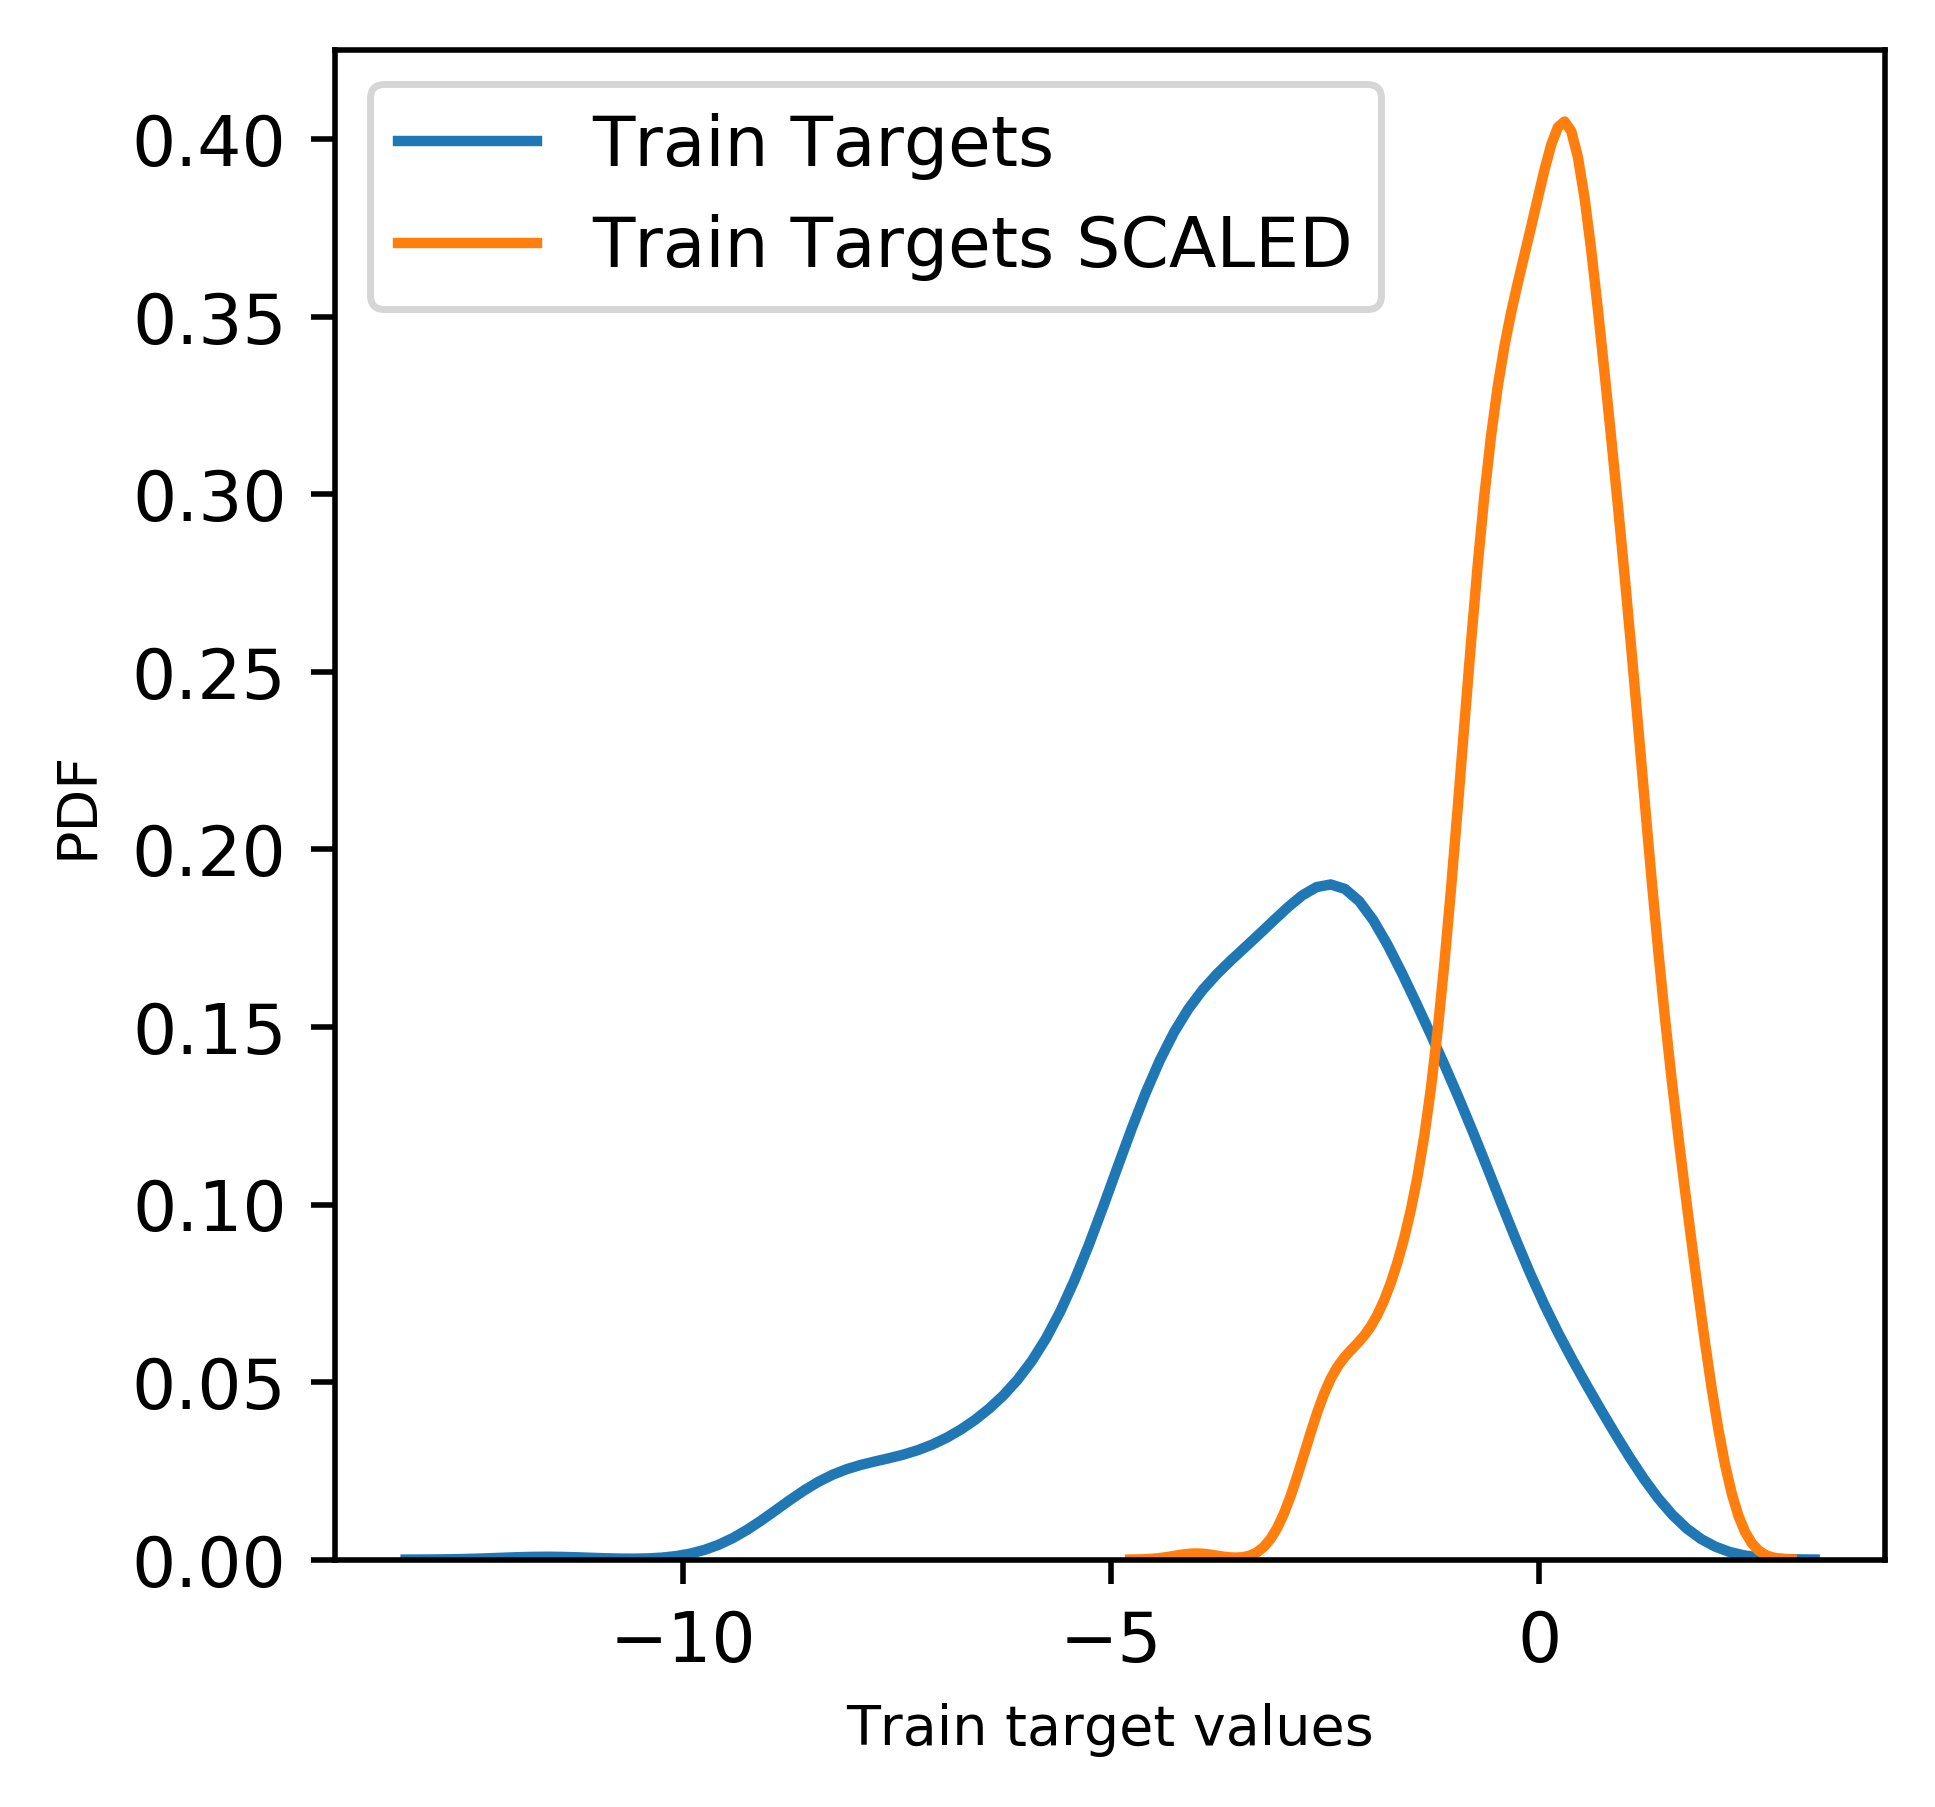

In [17]:
# PDF of the Train Targets, original vs standardised
fig=plt.figure(num=None,figsize=(4,4),dpi=500,facecolor='w',edgecolor='k')
sns.distplot(TrainTargets, rug=False, label="Train Targets", hist=False)
sns.distplot(TrainTargets_s, rug=False, label="Train Targets SCALED", hist=False)
plt.xlabel('Train target values',fontsize=8)
plt.ylabel('PDF',fontsize=8)
plt.show()

<div class=warn>
Scale the test and train target values so that they lie in the -1,+1 range using a so-called MinMax scaler
<div/>

At this stage, we are ready to build a neural network. Scikit-learn makes this task embarassingly easy. The full set of keywords available can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html), but the main parameters we can play with are:

- **hidden_layer_sizes**: this specifies the architecture of your neural network. For instance, hidden_layer_sizes = (5, 5, 5) implies that we have three hidden layers, each one containing 5 nodes.
- **activation**: the functional form of the non-linear activation functions which are to be applied to the nodes in the hidden layers.
- **solver**: the optimisation algorithm that will attempt to modify the weights so as to minimise the cost function.
- **learning_rate**: the rate at which the weights are optimised after each epoch. Say, a learning rate of 0.1 means that the weight are updated by 10% of the estimated weight error each epoch. The higher the learning rate...
- **alpha**: quantifies the degree of regularisation, i.e. the extent to which high-valued regression coefficient are penalised. In particular, this parameter is about L2 regularisation, which applies a penalty equal to the square of the magnitude of coefficient. Regularisation is useful to both avoid overfitting and getting stuck into numerical instability. Visual example: what would you use to fit two points - a straight line or an order 8 polynomial? regularisation makes the right (simple) choice for you.
- **random_state**: seed for the random number generator. If = None, np.random is used.
- **max iter**: the maximum number of epochs (algorithms in scikit-learn tend to have convergence threshold which force them to stop if met).

In [57]:
from sklearn.neural_network import MLPRegressor
nn=MLPRegressor(hidden_layer_sizes = (100, 100, 100, 100), activation = 'tanh', solver = 'sgd', \
                learning_rate='adaptive', alpha = 0.01, random_state = None, max_iter=500)
nn.fit(SDTR,TrainTargets_s.ravel());

In [58]:
# Use the trained NN to predict the solubility of our training set...
TrainPred=nn.predict(SDTR).reshape(-1,1)
# ... and of our test set
TestPred=nn.predict(SDTE).reshape(-1,1)
# The reshape(-1,1) bit is needed to convert numpy arrays into scikit-learn compatible inputs...

In [59]:
from sklearn.metrics import mean_squared_error

# How are we doing? 
# Let us calculate the mean squared error of our prediction for the training set 
# with respect to the actual solubility values
mse_train=mean_squared_error(TrainTargets,TrainPred)
print("MSE (training)) = ", mse_train)

# Now let's do the same for the test set...
mse_test=mean_squared_error(TestTargets,TestPred)
print("MSE (test)) = ", mse_test)

MSE (training)) =  11.297922197962716
MSE (test)) =  10.670606232694542


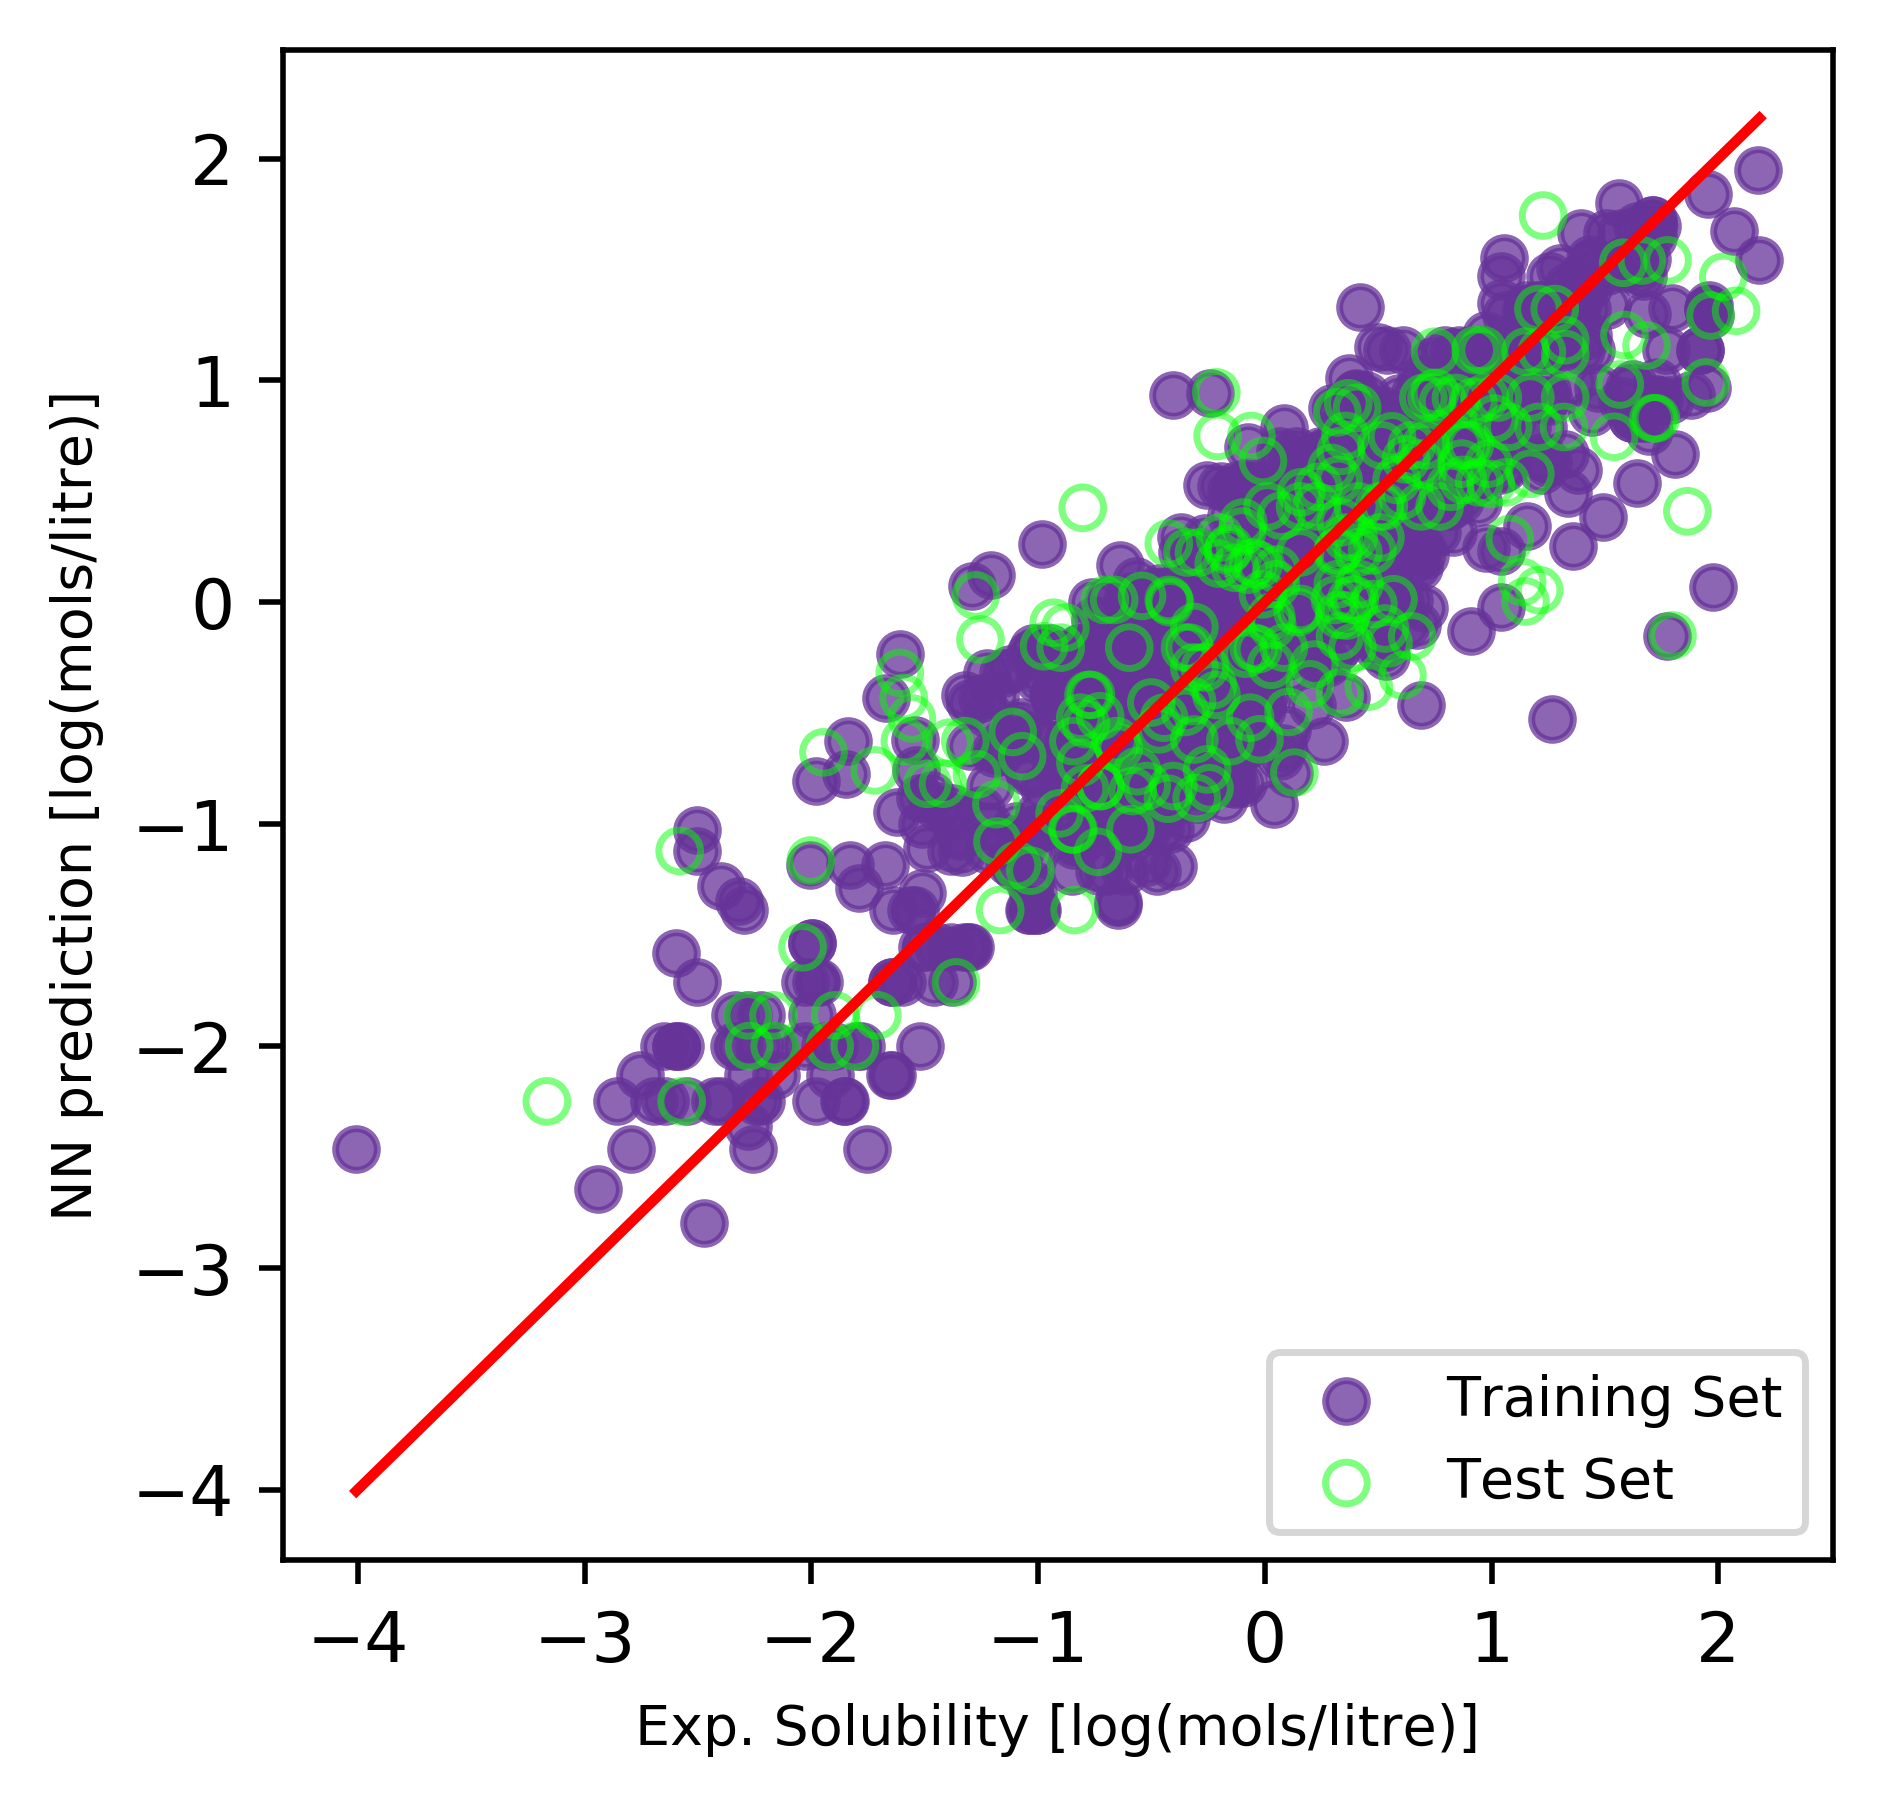

In [21]:
# Let's have a look!
fig=plt.figure(num=None,figsize=(4,4),dpi=500,facecolor='w',edgecolor='k')
plt.xlabel('Exp. Solubility [log(mols/litre)]',fontsize=8)
plt.ylabel('NN prediction [log(mols/litre)]',fontsize=8)
x = np.linspace(min(TrainTargets_s), max(TrainTargets_s), 1000)
plt.plot(x, x + 0, '-r')
plt.scatter(TrainTargets_s,TrainPred,color='rebeccapurple',alpha=0.75,label='Training Set')
plt.scatter(TestTargets_s,TestPred,color='lime',alpha=0.5,label='Test Set',facecolors='none')
plt.legend(fontsize=8,loc=4);
#plt.savefig('4.png');